In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import beta

plot_settings = {'title':14, 'text':12, 'annotation':10, 'figsize':(16,8)}

Por Miguel Ángel Castañeda Martínez.

<div style="text-align: justify">
Cuando empecé mi trayectoria como científico de datos tenía escaso conocimiento de lenguajes de programación, modelos de aprendizaje de máquina, análisis exploratorio de datos, etc. En un inicio imaginaba que la analítica de datos iba más por el camino de los sistemas, el poder computacional, y los algoritmos, pero nunca imaginé que tuviera algo que ver con estadística. Para mí la estadística era una materia más con la que se tenía que cumplir en la carrera, la veía como algo arcaico incluso tedioso. Poco imaginaba que años después terminaría siendo de mis temas favoritos, que encontraría fascinante el inmenso mundo del que se trata, y que me daría cuenta del enorme abanico de aplicaciones que tiene.

En este breve artículo intento mostrar, con un ejemplo aplicado, las diferencias entre un enfoque frecuentista y un enfoque bayesiano. Cabe destacar que es la opinión de una persona que empieza a adentrarse en el mundo de la estadística bayesiana, que considera que la mejor manera de asimilar el conocimiento es compartiéndolo, y que por tanto está haciendo un esfuerzo por transmitir sus primeras impresiones e intuiciones del tema.

El ejemplo que utilizaré para mostrar los conceptos es con datos de encuestas realizadas para la elección presidencial del 2008 en Estados Unidos, mismos que se pueden encontrar en el portal de [Pew Research Center](https://www.pewresearch.org/). Este ejemplo es una expansión de un trabajo realizado para la materia de [Fundamentos de estadística](https://tereom.github.io/fundamentos-2022/) impartida en la [Maestría en Ciencia de Datos](https://mcdatos.itam.mx/es) del [ITAM](https://www.itam.mx/), por quien rápidamente se posicionaría como una de las mejores profesoras que he tenido en mi trayectoria profesional, [Teresa Ortiz](https://tereom.netlify.app/).

## El problema

Como es bien sabido, la elección de Estados Unidos en el 2008 la ganó el candidato presidencial por el partido demócrata, Barack Obama. Se podría pensar que existe cierta correlación entre la proporción de votos que recibió Obama, con la proporción de votantes que se identifican liberales en cada estado, por lo que para ilustrar ambos enfoques, se realizará una comparación entre la proporción de la población de cada estado que tiene ideología política "muy liberal" (en lo subsecuente _very liberal_), contra el porcentaje de votos que recibió el candidato en cada estado.

Para hacer dicha comparación se tienen dos conjuntos de datos, el primero de ellos es el de las encuestas realizadas a la ciudadanía del país, para el cual cada registro es una persona encuestada, y son de interés las siguientes variables:

* `state`: Estado en el que se realizó la encuesta.
* `survey`: Identificador de la encuesta aplicada en cada registro.
* `ideo`: Ideología política del encuestado.

El segundo de ellos contiene los resultados de la elección por estado, para el cual el foco de atención estará en las siguientes variables:

* `state`: Estado de referencia.
* `vote_Obama_pct`: Porcentaje de votos por Obama.

</div>

<div style="text-align: justify">

## Enfoque frecuentista

Para la primera parte del análisis se obtendrá la proporción de la población que se identifica _very liberal_ utilizando un enfoque frecuentista, es decir, se puede obtener la proporción de máxima verosimilitud utilizando una distribución binomial. Para ello, se puede ver a cada uno de los $n$ encuestados de un estado en particular $X = \{x_1,x_2,...,x_n\}$, como $n$ muestras de una variable aleatoria independiente e idénticamente distribuida, y que siguen una distribución $x_i \backsim B(n=1, p=\theta)$, en donde una persona con dicha ideología es considerada como un éxito bajo una binomial.

El estimador de máxima verosimilitud para una distribución binomial bajo $n=1$ está dada por:

$$\theta = \bar x$$

En el caso del ejemplo, se puede obtener dicho estimador de proporción (`prop_mle`) utilizando el total de las encuestas realizadas en un estado (`survey_total`), y el total de encuestados que se identificaron _very liberal_ (`survey_very_lib`) en su ideología política. Esto se observa con mayor detalle en la siguiente tabla, misma que por simplicidad solamente muestra los primeros cinco estados.

**Nota**: La demostración del estimador $\theta$ se puede encontrar en el Anexo 1.

</div>

In [2]:
#Carga de datos de encuestas
poll_data = pd.read_stata('./pew_research_center_june_elect_wknd_data.dta')

#Paso 1: Se agrupa por estado para obtener el número de encuestas realizadas en cada estada
state = poll_data.groupby(by='state').count()
state.reset_index(inplace=True)
state = state[['state', 'survey']]

#Paso 2: Se agrupa por estado e ideología para filtrar encuestas very liberal
ideo = poll_data.groupby(by=['state','ideo']).count()
ideo.reset_index(inplace=True)
ideo = ideo[['state', 'ideo', 'survey']]
very_liberal = ideo.loc[ideo['ideo'] == 'very liberal']

#Paso 3: Se unen los dos conjuntos anteriores
prop = pd.merge(left=state,
                right=very_liberal,
                how='left',
                on='state',
                suffixes=('_total','_very_lib'))

#Paso 4: Se crea obtiene la proporción de very libera de máxima verosimilitud por estado
prop['prop_mle'] = prop['survey_very_lib'] / prop['survey_total']

#Paso 5: Se eliminan estados que no son de interés
prop = prop[~prop['state'].isin(['washington dc', 'hawaii', 'alaska'])]
prop.head()

,state,survey_total,ideo,survey_very_lib,prop_mle
0,alabama,624,very liberal,30,0.048077
1,arizona,542,very liberal,28,0.051661
2,arkansas,307,very liberal,7,0.022801
3,california,2854,very liberal,179,0.062719
4,colorado,468,very liberal,27,0.057692


<div style="text-align: justify">

Algunas cosas que se pueden destacar de la tabla anterior, es que a pesar de que algunos estados pudieran presentar la misma proporción de _very liberal_, no necesariamente representa una cantidad significativa de votantes ya que esto depende de la población de cada estado. Tal es el caso de California comparado con Colorado, en donde porcentualmente tienen proporciones similares con $6.3\%$ y $5.8\%$ respectivamente, pero en el total de encuestas California es mucho mayor.
    
Para tener idea del panorama de la proporción de _very liberal_ comparado con el número de encuestas para cada uno de los estados, se puede realizar la siguiente visualización:

</div>

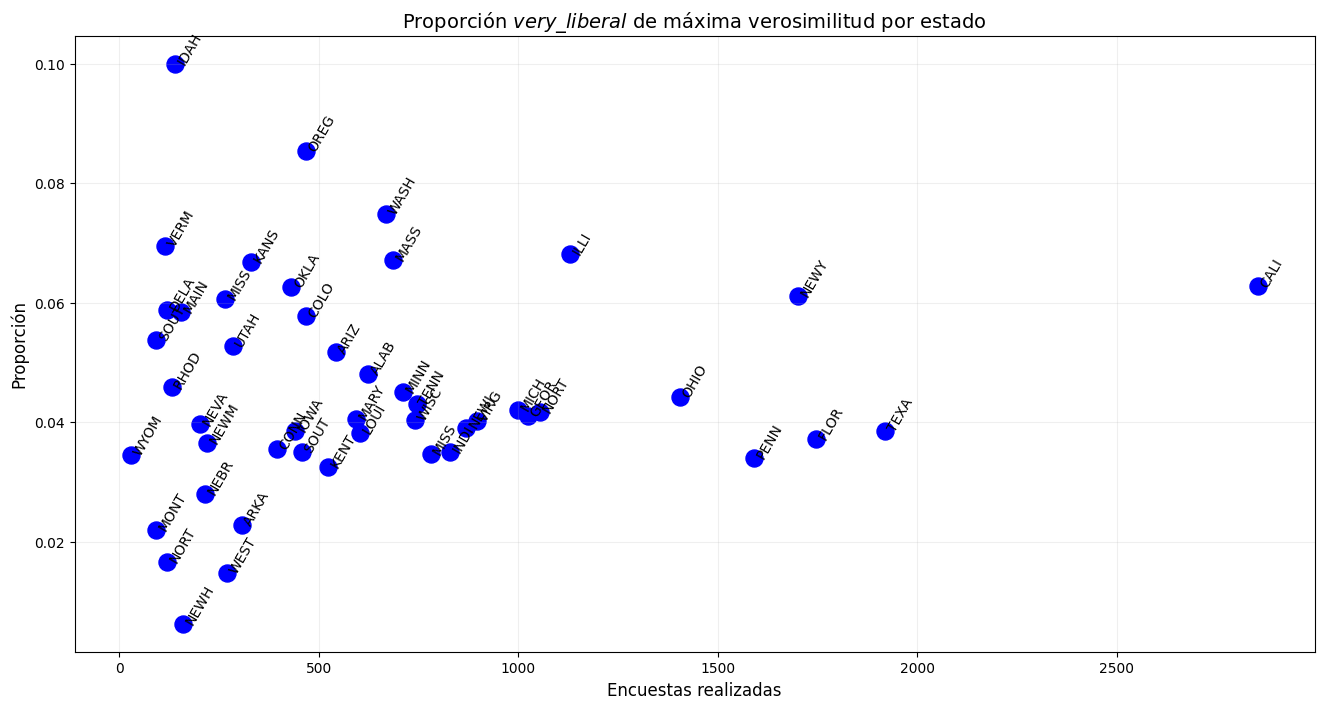

In [3]:
#Scatter plot
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], s=150, color='blue')

#Anotaciones y estilo
for idx in prop.index:
    x = prop.loc[idx]['survey_total']
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=plot_settings['annotation'], rotation=60)
plt.title(r'Proporción $very\_liberal$ de máxima verosimilitud por estado', fontsize=plot_settings['title'])
plt.xlabel('Encuestas realizadas', fontsize=plot_settings['text'])
plt.ylabel('Proporción', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)

plt.show()

<div style="text-align: justify">

Se puede ver que la proporción de máxima verosimilitud de personas con ideología _very liberal_ no incrementa linealmente con el tamaño de la población, de hecho, si se observa con detenimiento, se puede identificar que estados como California, Nueva York, o Texas, en donde se realizó un mayor número de encuestas, tienden a estar centrados en torno a una proporción del $5\%$. Lo anterior es contrastante con los estados en los que se realizaron menos de 500 encuestas, mismos que tienen mayor dispersión entre sí resultando en una gráfica que tiende a ser un cono que se abre a menor número de encuestas, pero que converge cuando estas aumentan.
    
Lo anterior puede dar una primera intuición de un enfoque frecuentista, y es que bajo esta lupa es razonable pensar que entre mayor sea el tamaño de la muestra, mayor convergencia se tendrá hacia el verdadero valor poblacional. En el caso de la proporción de personas _very liberal_ se podría pensar que cada uno de los estados son una representación del comportamiento general de todo el país, por ende, si en el país la proporción de personas con dicha ideología es del $5\%$, entonces los diferentes estados tendrían que tener proporciones centradas en torno a este valor con una determinada varianza.

Se puede hacer entonces una inspección visual del comportamiento de la proporción de personas _very liberal_ contrastando el porcentaje de votos que recibió Obama. Para ello, primero es necesario resaltar que son características que se encuentran en diferentes escalas de magnitud, y se pretende hacer una comparacación de la tendencia o distribución de los datos partiendo de la idea inicial del artículo, es decir, que existe cierta correlación entre la proporción de votos que recibió Obama, con la proporción de votantes que se identifican liberales en cada estado, por lo que para poder compararlas es necesario representarlas en la misma escala. 
    
Dicho lo anterior, entonces se puede hacer la siguiente visualización:

</div>

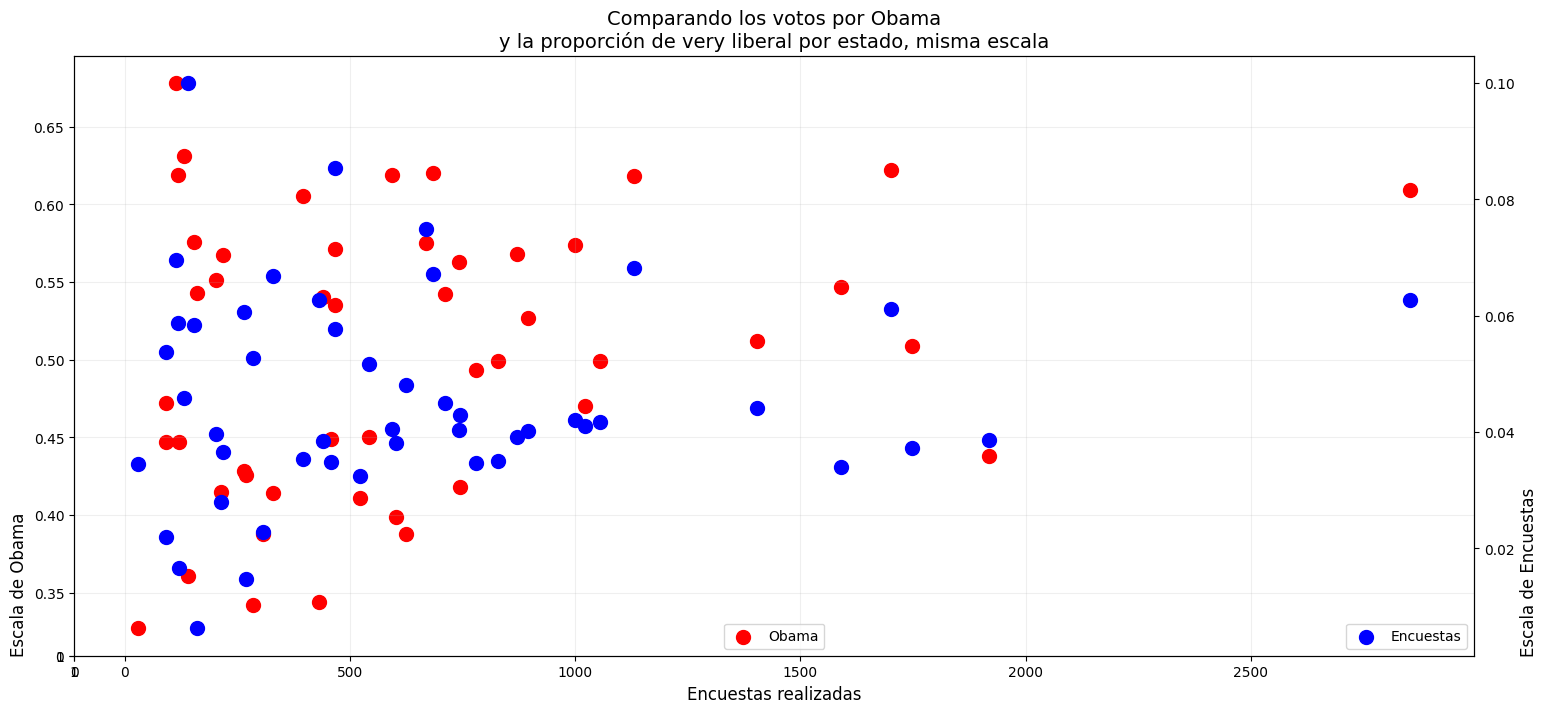

In [4]:
#Carga de datos de las elecciones
results = pd.read_csv('./2008ElectionResult.csv')

#Paso 1: Descartar estados que no son de interés
results = results[~results['state'].isin(['District of Columbia', 'Hawaii', 'Alaska'])]

#Paso 2: Formatear el nombre de los estados para compatibilidad
results['state'] = results['state'].str.lower()

#Paso 3: Se incorpora la información al conjunto de datos
prop = pd.merge(left=prop,
                right=results[['state', 'vote_Obama_pct']],
                how='left',
                on='state')

#Graficando en misma escala votos por Obama y proporción very liberal MLE
fig = plt.figure(figsize=(14,6))
s = 100

#Gráficas
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0, 0, 0, 0]) #
ax2 = ax1.twinx()
lns1 = ax1.scatter(x=prop['survey_total'], y=prop['vote_Obama_pct']/100, color='red', s=s, label='Obama')
lns2 = ax2.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='blue', s=s, label='Encuestas')

#Anotaciones y estilo
ax1.set_xlabel('Encuestas realizadas', fontsize=plot_settings['text'])
ax1.set_ylabel('Escala de Obama', fontsize=plot_settings['text'], loc='bottom')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Escala de Encuestas', fontsize=plot_settings['text'],  loc='bottom')
ax1.legend(loc=8, fontsize=plot_settings['annotation']); ax2.legend(loc=4, fontsize=plot_settings['annotation'])
plt.title('Comparando los votos por Obama\ny la proporción de very liberal por estado, misma escala', fontsize=plot_settings['title'])
ax1.grid(alpha=0.2)
    
plt.show()

Con la visualización anterior se vuelve evidente que el número de votos que tuvo Obama por estado sigue un patrón sumamente similar a la proporción de personas por estado que se consideran _very liberal_.

Se grafican los votos por Obama contra la proporción de liberales

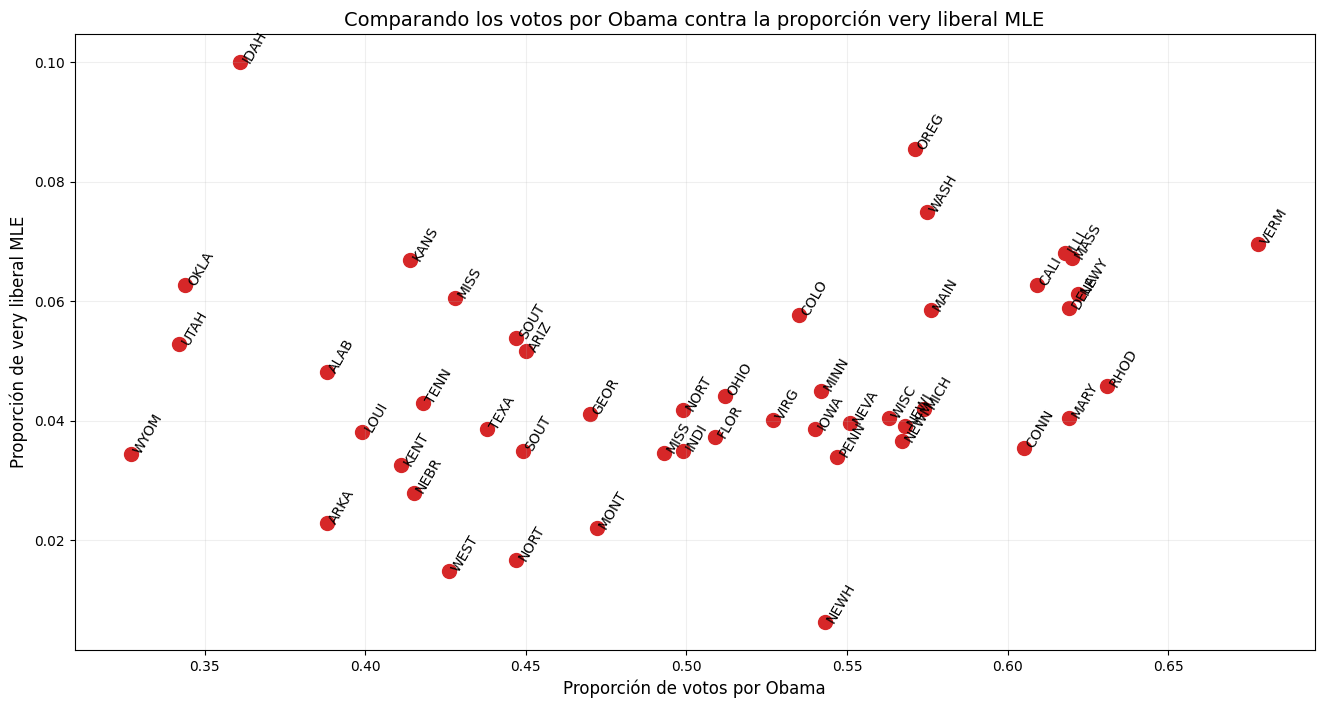

In [5]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_mle'], color='tab:red', s=100)

for idx in prop.index:
    x = prop.loc[idx]['vote_Obama_pct']/100
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=plot_settings['annotation'], rotation=60)

plt.title('Comparando los votos por Obama contra la proporción very liberal MLE', fontsize=plot_settings['title'])
plt.xlabel('Proporción de votos por Obama', fontsize=plot_settings['text'])
plt.ylabel('Proporción de very liberal MLE', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)

plt.show()

En general, del gráfico anterior se ve una ligera tendencia a que Obama tenga una mayor proporción de votantes por estado a medida que la proporción de personas _very liberal_ aumenta.

Esta tendencia se rompe en estados como `IDAH`, `OKLA`, en donde se esperaría que Obama hubiera tenido mayor proporción de votantes; o `NEWH`, en donde se esperaría que no hubiera tenido tantos votos

## Enfoque Bayesiano
**Paso 1**: Generamos una función para calcular los parámetros $a$, $b$ de la inicial dados los valores de $\mu$, $\sigma$.

In [6]:
def get_beta_params(mu, var): 
    a = mu * (-mu**2 + mu - var) / var
    b = (mu - 1) * (mu**2 - mu + var) / var
    return [a, b]

**Paso 2**: Inspeccionamos visualmente el comportamiento de las proporciones por estado.

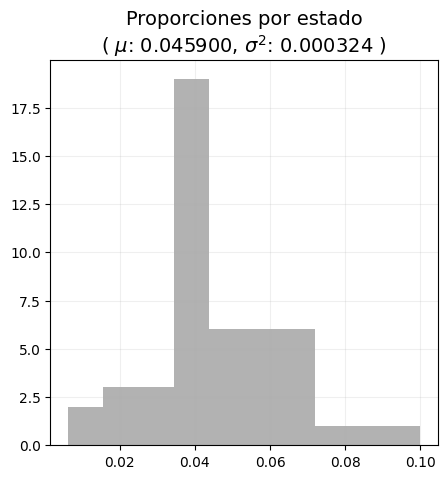

In [7]:
m = prop['prop_mle'].mean()
s2 = prop['prop_mle'].var()

fig, ax = plt.subplots(figsize=(5,5))

plt.hist(x=prop['prop_mle'], color='grey', alpha=0.6)
plt.title(f"Proporciones por estado\n( $\mu$: {m:.6f}, $\sigma^2$: {s2:.6f} )", fontsize=plot_settings['title'])
plt.grid(alpha=0.2)

plt.show()

**Paso 3**: Tomando la media y la varianza de la distribución anterior, obtenemos los valores $a$, $b$ de la distribución inicial.

In [8]:
a, b = get_beta_params(m, s2)

**Paso 4**: Comparamos las iniciales y las posteriores de 9 estados de interés

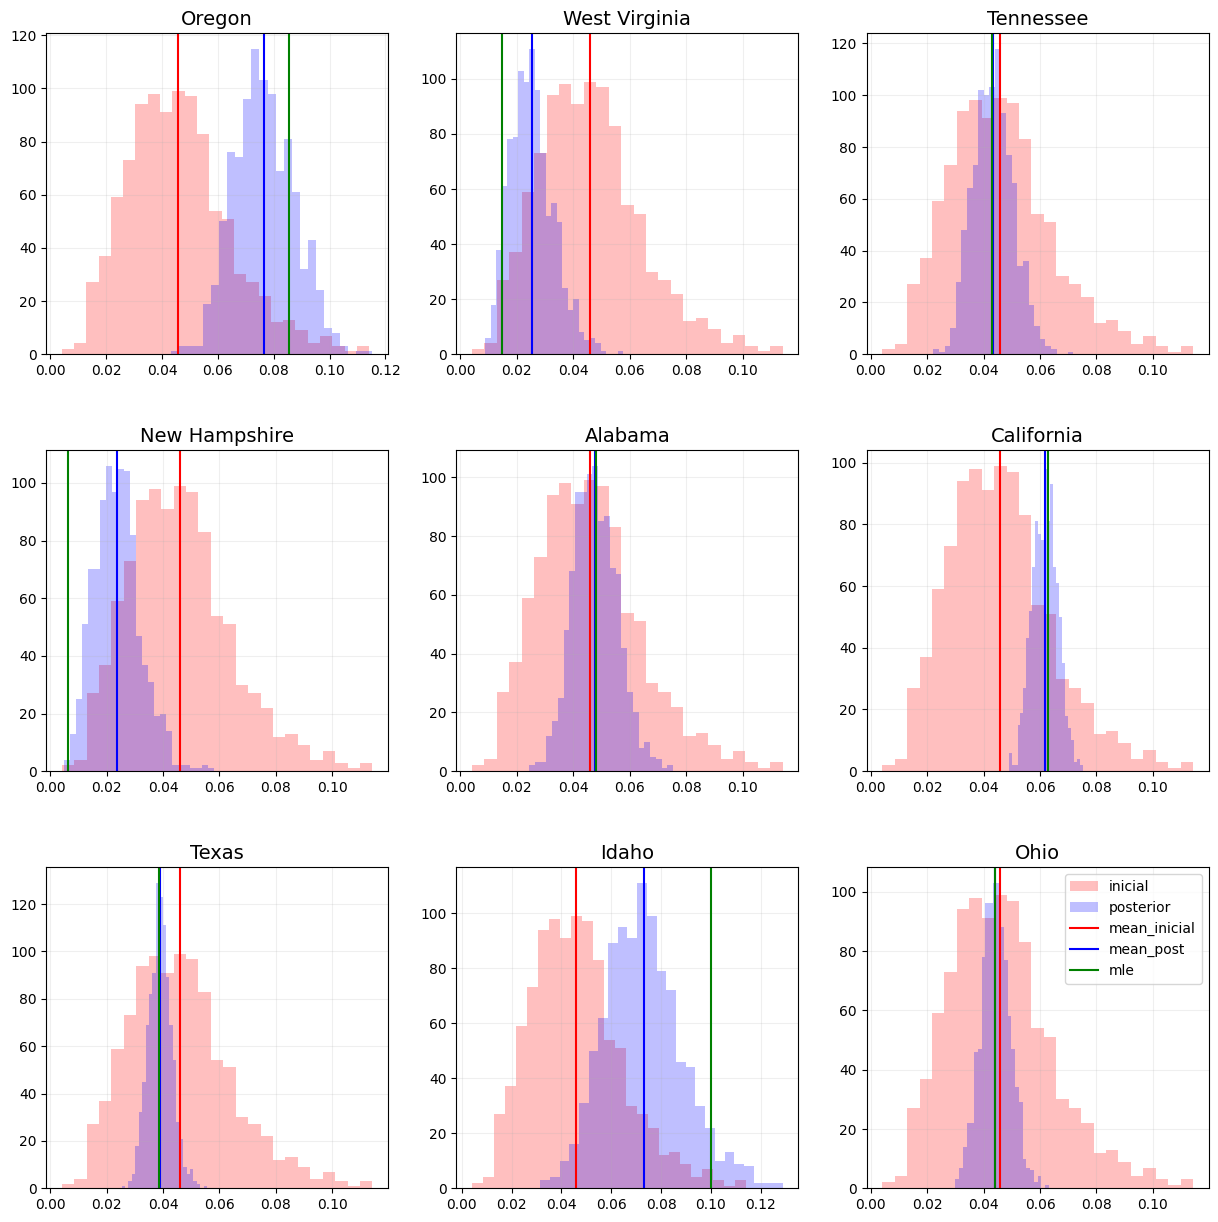

In [9]:
#Parámetros de simulación
sims = 1_000
inicial = beta.rvs(a=a, b=b, size=sims)
inicial_mean = inicial.mean()

#Parámetros de panel
panels = 3
states_idx = [34,45,39,26,0,3,40,9,32]

#Parámetros de figura
fig = plt.figure(figsize=(15,15))
spec = plt.GridSpec(ncols=panels, nrows=panels, hspace=0.3)
k = 0
for idx in states_idx:
    state = prop.loc[idx]['state']
    
    #Cálculo de la posterior
    n = prop.loc[idx]['survey_total']
    x = prop.loc[idx]['survey_very_lib']
    posterior = beta.rvs(a=(a+x), b=(b+n-x), size=sims)
    
    #Gráficas
    ax_n = f"ax{k}"
    ax_n = fig.add_subplot(spec[k])
    ax_n.hist(x=inicial, bins=25, color='red', alpha=0.25, label='inicial')
    ax_n.hist(x=posterior, bins=25, color='blue', alpha=0.25, label='posterior')
    ax_n.axvline(x=inicial.mean(), color='red', label='mean_inicial')
    ax_n.axvline(x=posterior.mean(), color='blue', label='mean_post')
    ax_n.axvline(x=prop.loc[idx]['prop_mle'], color='green', label='mle')
    
    #Anotaciones y estilo
    ax_n.set_title(state.title(), fontsize=14)
    ax_n.set_xlabel('')
    ax_n.grid(alpha=0.2)
    
    k += 1
#Anotaciones generales.
plt.legend()
    
plt.show()

<div style="text-align: justify">
La relevancia del panel anterior radica en que se puede ver con claridad el efecto de la verosimilitud de cada estado en la distribución inicial. Al considerar la misma inicial para todos los estados se está modelando el comportamiento promedio del país sobre cada uno de los estados. Sin embargo, al haber modelado la verosimilitud de cada estado de manera independiente, se puede ver que la posterior de cada uno tiene comportamientos distintos dependiendo de varios posibles factores, por ejemplo:

* Si la verosimilitud está por debajo de la inicial, entonces la posterior se mueve hacia la izquierda.
* Por el contrario, si la verismilitud es mayor a la inicial entonces la posterior se recorre hacia la derecha.
* Si se trata de un estado con poca represantación en las encuestas, entonces la inicial domina sobre la verosimilitud y vicecersa.
* Finalmente, en todos los casos se satisface que la posterior es un punto intermedio entre la inicial y la verosimilitud.

Obtenemos el estimador de la posterior para todos los estados
</div>

In [10]:
#Se crea columna vacía en dataframe
prop['prop_bayes'] = np.nan

for idx in prop.index:
    #Cálculo de la posterior
    n = prop.loc[idx]['survey_total']
    x = prop.loc[idx]['survey_very_lib']
    posterior_mean = beta.rvs(a=(a+x), b=(b+n-x), size=sims).mean()
    
    prop.loc[prop.index == idx, 'prop_bayes'] = posterior_mean

Comparamos el desplazamiento del estimador MLE provocado por la distribucón inicial bajo un enfoque bayesiano

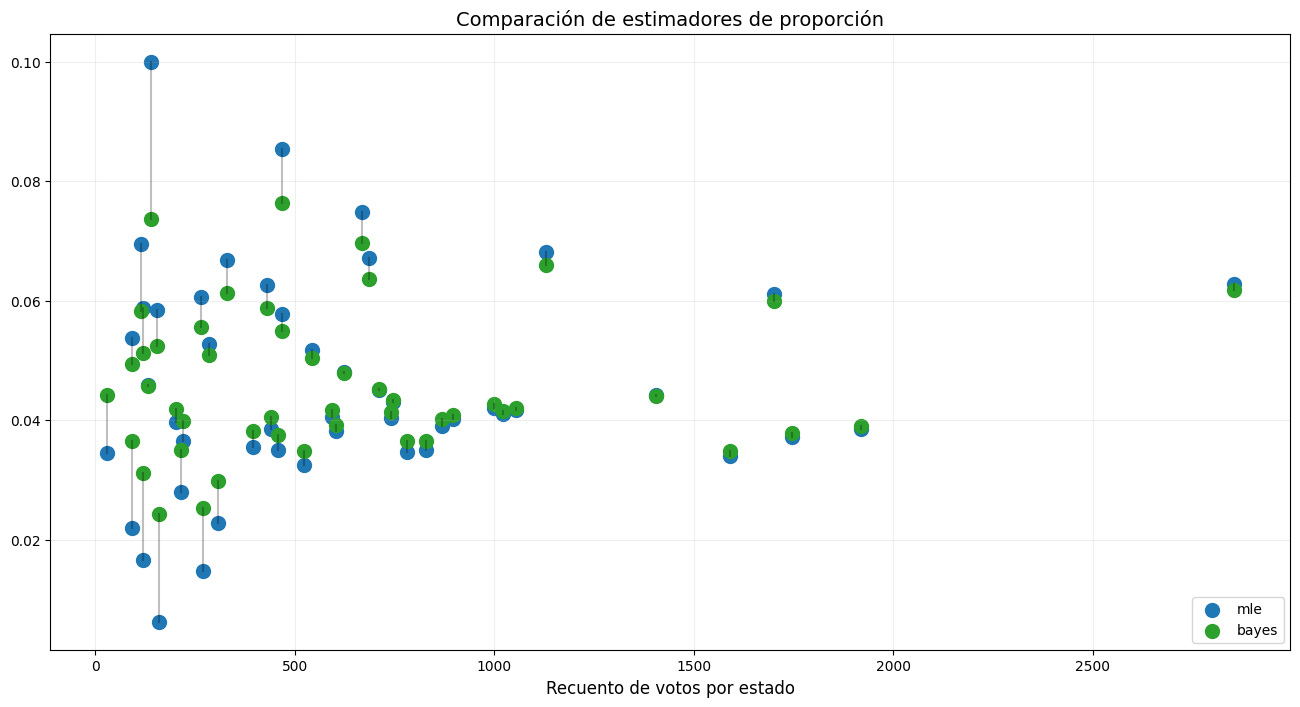

In [11]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='tab:blue', s=100, label='mle')
plt.scatter(x=prop['survey_total'], y=prop['prop_bayes'], color='tab:green', s=100, label='bayes')

for idx in prop.index:
    x = prop.loc[idx]['survey_total']
    y_mle = prop.loc[idx]['prop_mle']
    y_bayes = prop.loc[idx]['prop_bayes']
    plt.plot([x,x], [y_mle, y_bayes], color='black', alpha=0.25)

plt.title('Comparación de estimadores de proporción', fontsize=plot_settings['title'])
plt.xlabel('Recuento de votos por estado', fontsize=plot_settings['text'])
plt.legend(fontsize=plot_settings['annotation'], loc=4)
plt.grid(alpha=0.2)

plt.show()

Nuevamente graficamos la proporción de votos que tuvo obama contra la proporción de _very liberal_ por estado, en esta ocasión con los resultados del enfoque bayesiano.

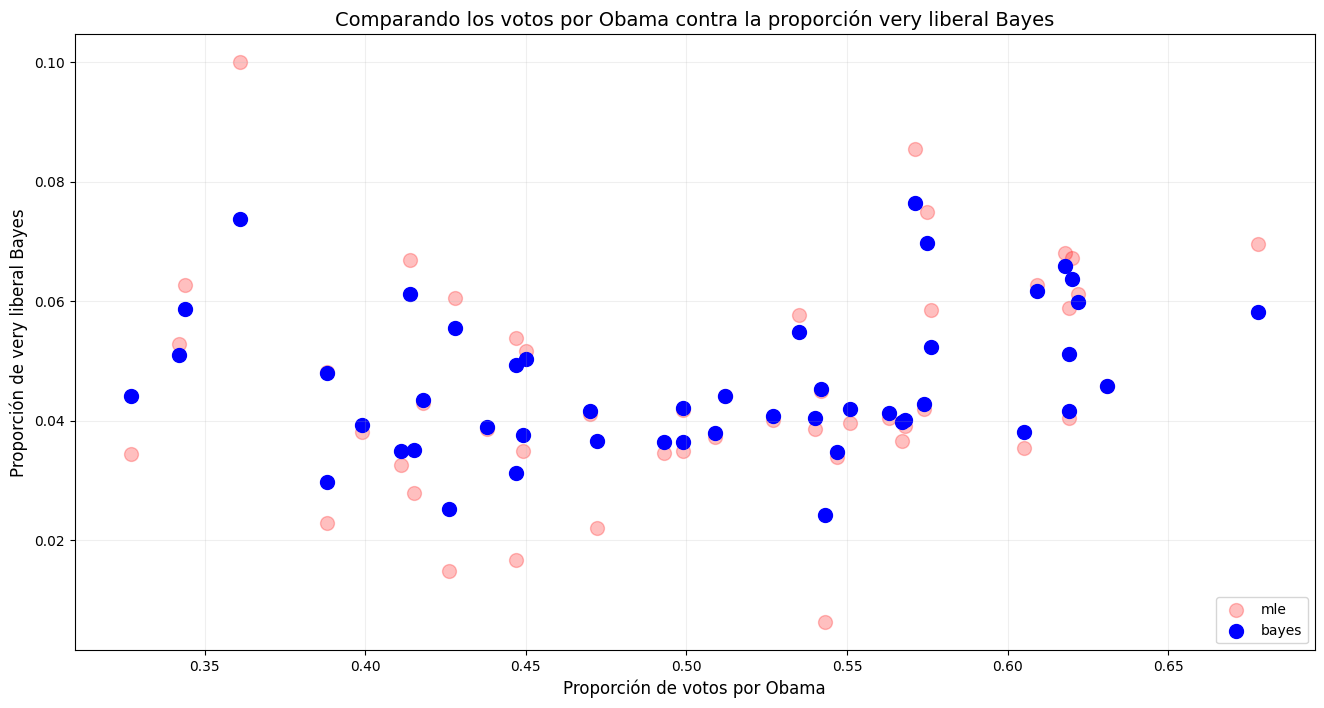

In [12]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_mle'], color='red', s=100, label='mle', alpha=0.25)
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_bayes'], color='blue', s=100, label='bayes')

plt.title('Comparando los votos por Obama contra la proporción very liberal Bayes', fontsize=plot_settings['title'])
plt.xlabel('Proporción de votos por Obama', fontsize=plot_settings['text'])
plt.ylabel('Proporción de very liberal Bayes', fontsize=plot_settings['text'])
plt.legend(fontsize=plot_settings['annotation'], loc=4)
plt.grid(alpha=0.2)

plt.show()

* Lo primero que notamos es que bajo este enfoque se reduce la dispersión de los puntos, manifestando un comportamiento relativamente más lineal que con el enfoque frecuentista.
* Adicionalmente, se mantiene la tendencia de que a mayor proporción de _very liberal_ en el estado mayor proporción de votos por Obama. Sin embargo, si bien la tendencia se mantiene la pendiente disminuye por la menor dispersión en los datos.

## Anexo 1
Utilizando el paquete de python `sympy` para cálculo simbólico, se obtuvieron las ecuaciones que resulven los parámetros $a$, $b$ de una distribución conjugada beta-binomial dados los valores de $\mu$, $\sigma$.

In [13]:
from sympy import symbols, Eq, solve
from sympy.abc import mu, sigma

In [14]:
a, b, s2, m = symbols("a b sigma^2 mu")

equation_1 = Eq( a / (a+b), m )
equation_2 = Eq( a*b / ((a+b)**2 * (a + b + 1)), s2 )
solution = solve((equation_1, equation_2), (a, b))

In [15]:
equation_1

Eq(a/(a + b), mu)

In [16]:
equation_2

Eq(a*b/((a + b)**2*(a + b + 1)), sigma^2)

In [17]:
print("Solución para el parámetro 'a':\n")
solution[0][0]

Solución para el parámetro 'a':



mu*(-mu**2 + mu - sigma^2)/sigma^2

In [18]:
print("Solución para el parámetro 'b':\n")
solution[0][1]

Solución para el parámetro 'b':



(mu - 1)*(mu**2 - mu + sigma^2)/sigma^2

Las expresiones anteriores se puegen programar directamente en una función de python

---